In [2]:
# ! pip install annoy
# ! pip install pymorphy2
# ! pip install stop_words

In [1]:
import os
import re
import pandas as pd
import pickle
import annoy
import string
import numpy as np
from sklearn.model_selection import train_test_split

from pymorphy2 import MorphAnalyzer
from stop_words import get_stop_words
from gensim.models import FastText

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# for reproducibility
import random
seed_value=42
random.seed(seed_value)
np.random.seed(seed_value)

# Загрузка файлов

In [2]:
print(os.listdir())

['.ipynb_checkpoints', 'data.csv', 'products.csv', 'Product_dict.pkl', 'rec_sys.ipynb', 'SimRecommenedExample.ipynb', 'чековые данные.csv']


## Файлы 'product.csv' и 'Product_dict.pkl'

In [3]:
with open('Product_dict.pkl', 'rb') as f:
    product_dict = pickle.load(f)

In [4]:
len(product_dict)

30418

In [5]:
product_dict['168308']

'(197312) Пакет-майка 25см х 45см 906'

In [6]:
products_df = pd.read_csv('products.csv')
products_df.head()

,product_id,product
0,168308,(197312) Пакет-майка 25см х 45см 906
1,134832,(62448) Перекись водорода р-р наружн. 3% фл.по...
2,101384,(72183) Салициловая кислота р-р спирт 2% фл 40...
3,168570,(197309) Пакет 28см х 50см 906
4,146960,"(111023) Пакет ""Аптека Озерки"" 28 х 35см 906"


In [7]:
products_df.shape

(30418, 2)

Файлы содержат одни и те же данные.

## Файл 'чековые данные.csv'

In [8]:
receipt_df = pd.read_csv('чековые данные.csv', low_memory=False, skiprows=[20000001, 20000002, 20000003])

In [9]:
receipt_df.tail()

,sale_date_date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity
19999995,2018-06-13,1601618,1499,66842,(111992) Кэа Хэлс Ромашка [цветки фильтр-пакет...,615,140,1838,"1,00"
19999996,2018-06-13,1394104,1495,136795,(97857) Лориста Н таб. п.о. 50мг+12.5мг №90,738,170,-1,"1,00"
19999997,2018-06-13,1570654,1516,119513,(25299) Локрен тб п/о 20мг N28,738,170,-1,"1,00"
19999998,2018-06-13,1924036,1485,71723,(60907) Тералиджен табл. п.п.о. 5 мг №25,637,146,-1,"1,00"
19999999,2018-06-13,1788779,1503,66164,(27922) Дифлюкан капс. 150 мг. №1,622,142,-1,"1,00"


In [10]:
receipt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000000 entries, 0 to 19999999
Data columns (total 9 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   sale_date_date           object
 1   contact_id               int64 
 2   shop_id                  int64 
 3   product_id               int64 
 4   name                     object
 5   product_sub_category_id  int64 
 6   product_category_id      int64 
 7   brand_id                 int64 
 8   quantity                 object
dtypes: int64(6), object(3)
memory usage: 1.3+ GB


Удалим дупликаты и пропуски, т.к. размер датасета достаточно большой.

In [11]:
receipt_df = receipt_df.dropna()
receipt_df.drop_duplicates(inplace=True)

In [12]:
receipt_df.shape

(19703842, 9)

Потеряли всего 1.5 % данных. Вполне допустимо.

# EDA

In [13]:
receipt_df.columns

Index(['sale_date_date', 'contact_id', 'shop_id', 'product_id', 'name',
       'product_sub_category_id', 'product_category_id', 'brand_id',
       'quantity'],
      dtype='object')

Переименуем столбцы для удобства дальнейшей обработки.

In [14]:
receipt_df.columns = ['sale_date', 'user', 'shop', 'item', 'name',
       'item_sub_cat', 'item_cat', 'brand', 'quantity']
receipt_df.head(3)

,sale_date,user,shop,item,name,item_sub_cat,item_cat,brand,quantity
0,2018-12-07,1260627,1455,168308,(197312) Пакет-майка 25см х 45см,906,205,-1,"1,00"
1,2018-12-07,198287,279,134832,(62448) Перекись водорода р-р наружн. 3% фл.по...,404,93,-1,"1,00"
2,2018-12-07,2418385,848,101384,(72183) Салициловая кислота р-р спирт 2% фл 40...,404,93,-1,"1,00"


Переведем некоторые столбцы в удобные форматы данных:

In [15]:
# приводим столбец с датами к формату pandas Timestamp
receipt_df['sale_date'] = pd.to_datetime(receipt_df['sale_date'])
# столбец quantity привоим к float формату из текста
receipt_df['quantity'] = receipt_df['quantity'].apply(lambda x: x.replace(",", ".")).apply(float)

### Анализ столбца 'brand'

In [16]:
print(f"Уникальных значений в столбце 'brand':   {receipt_df['brand'].nunique()}")
print(f"Максимальное значение в столбце 'brand': {receipt_df['brand'].max()}")
print(f"Минимальное значение в столбце 'brand':  {receipt_df['brand'].min()}")

Уникальных значений в столбце 'brand':   1631
Максимальное значение в столбце 'brand': 5475
Минимальное значение в столбце 'brand':  -1


In [17]:
receipt_df['brand'].value_counts()

-1       15927786
 1520      870683
 1348      148578
 2038      104215
 4538       96452
           ...   
 4877           1
 1433           1
 932            1
 4235           1
 4529           1
Name: brand, Length: 1631, dtype: int64

In [18]:
receipt_df.query('brand==-1').sample(5)

,sale_date,user,shop,item,name,item_sub_cat,item_cat,brand,quantity
6257158,2018-01-13,310456,329,8106,(107900) Кардиомагнил таб.п.п.о. форте 150мг №30,738,170,-1,1.0
5119903,2018-01-29,1383527,1461,112984,(64739) Галавит таблетки подъязычные 25мг №20,581,130,-1,1.0
8834870,2018-03-22,452884,275,140779,"(66631) Валз Н табл. п.о. 160 мг. + 12,5 мг. №28",738,170,-1,1.0
19180642,2018-06-02,1217150,848,40013,(4395) Фликсоназе спрей наз. доз. 50 мкг/доза ...,395,89,-1,1.0
11679100,2018-04-03,1044946,278,140029,"(16185) Гутталакс капли д/приема внутрь 7,5 мг...",598,135,-1,1.0


Более чем у 75 % записей, судя по всему, отсутствует указание бренда (brand=='-1'), поэтому данный столбец в рекоммендациях учитывать не будем.

### Анализ столбца 'quantity'

In [19]:
print(f"Уникальных значений в столбце 'quantity':   {receipt_df['quantity'].nunique()}")
print(f"Максимальное значение в столбце 'quantity': {receipt_df['quantity'].max()}")
print(f"Минимальное значение в столбце 'quantity':  {receipt_df['quantity'].min()}")

Уникальных значений в столбце 'quantity':   1244
Максимальное значение в столбце 'quantity': 10000.0
Минимальное значение в столбце 'quantity':  0.001


Проверим на выбросы:

<Axes: >

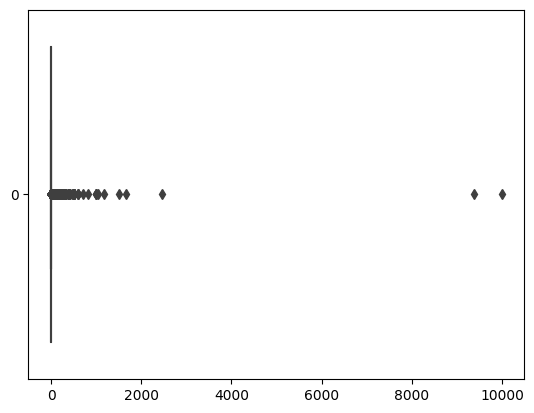

In [20]:
sns.boxplot(receipt_df['quantity'], orient='h')

In [21]:
# уже на этом этапе видно, что некоторые item можно удалить, например, пакеты, карты, НДС, и бахилы
receipt_df = receipt_df.query('item not in [129195, 158662, 193351, 68689, 217227]')
receipt_df.shape

(19461050, 9)

In [22]:
np.quantile(receipt_df['quantity'], .99)

10.0

С учетом того, что 99-й процентиль равен 10, то отбросим значения выше этого порога.

In [23]:
receipt_df = receipt_df.query('quantity<=10')
receipt_df.shape

(19377654, 9)

In [24]:
# округлим в большую сторону все дробные части и переведем в целочисленный формат
receipt_df['quantity'] = receipt_df['quantity'].apply(np.ceil).apply(int)

<Axes: >

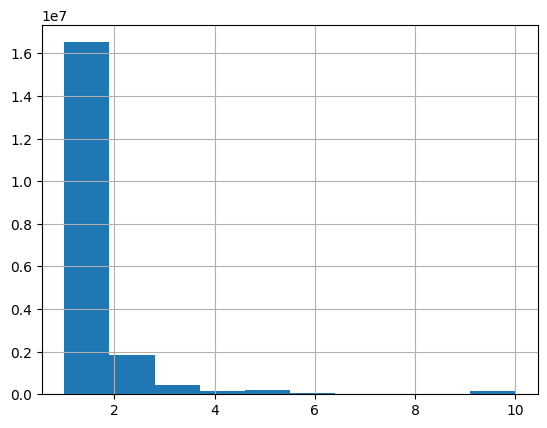

In [25]:
receipt_df['quantity'].hist()

In [26]:
print(f"Уникальных значений в столбце 'quantity':   {receipt_df['quantity'].nunique()}")
print(f"Максимальное значение в столбце 'quantity': {receipt_df['quantity'].max()}")
print(f"Минимальное значение в столбце 'quantity':  {receipt_df['quantity'].min()}")

Уникальных значений в столбце 'quantity':   10
Максимальное значение в столбце 'quantity': 10
Минимальное значение в столбце 'quantity':  1


In [27]:
receipt_df['quantity'] = receipt_df['quantity'].astype('int32')

### Анализ столбцов подкатегорий и категорий

In [28]:
print(f"Уникальных значений в столбце 'item_sub_cat':   {receipt_df['item_sub_cat'].nunique()}")
print(f"Максимальное значение в столбце 'item_sub_cat': {receipt_df['item_sub_cat'].max()}")
print(f"Минимальное значение в столбце 'item_sub_cat':  {receipt_df['item_sub_cat'].min()}")

Уникальных значений в столбце 'item_sub_cat':   440
Максимальное значение в столбце 'item_sub_cat': 939
Минимальное значение в столбце 'item_sub_cat':  -1


<Axes: >

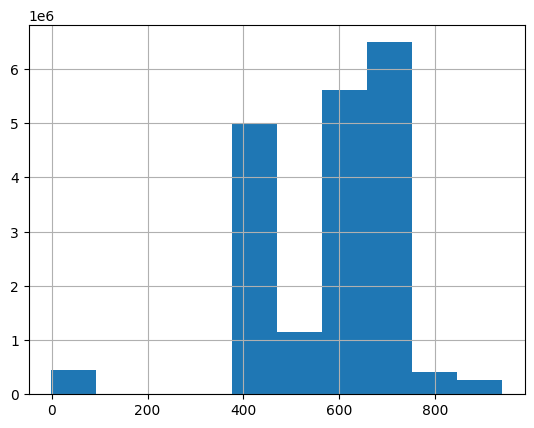

In [29]:
receipt_df['item_sub_cat'].hist()

In [30]:
receipt_df['item_sub_cat'].value_counts()

738    2521338
397     829769
595     740450
701     580343
404     569104
        ...   
832          1
886          1
809          1
483          1
660          1
Name: item_sub_cat, Length: 440, dtype: int64

In [31]:
sub_cat_map_to_arti = {i[1]: i[0] for i in enumerate(receipt_df['item_sub_cat'].unique())}
sub_cat_map_to_real = {i[0]: i[1] for i in enumerate(receipt_df['item_sub_cat'].unique())}

In [32]:
receipt_df['item_sub_cat'] = [sub_cat_map_to_arti[sub_cat] for sub_cat in receipt_df['item_sub_cat']]

In [33]:
print(f"Уникальных значений в столбце 'item_sub_cat':   {receipt_df['item_sub_cat'].nunique()}")
print(f"Максимальное значение в столбце 'item_sub_cat': {receipt_df['item_sub_cat'].max()}")
print(f"Минимальное значение в столбце 'item_sub_cat':  {receipt_df['item_sub_cat'].min()}")

Уникальных значений в столбце 'item_sub_cat':   440
Максимальное значение в столбце 'item_sub_cat': 439
Минимальное значение в столбце 'item_sub_cat':  0


In [34]:
receipt_df['item_sub_cat'] = receipt_df['item_sub_cat'].astype('int16')

In [35]:
# вручную убираем часть мусорных данных
receipt_df = receipt_df.query('item not in [192349, 192552, 216032, 192885, 192867, 192889, 192789, 215286, 192578, 192920, 192906, 192513, 192571, 217217, 193640, 192686, 192763, 216031, 192894, 192753, 192557, 216064, 192556, 192347, 192572, 216024, 216045, 192834, 192915, 213615, 192674, 192723, 192350, 192807, 192332, 94270, 94270, 192785, 192880]')
receipt_df.shape

(19223516, 9)

In [36]:
print(f"Уникальных значений в столбце 'item_cat':   {receipt_df['item_cat'].nunique()}")
print(f"Максимальное значение в столбце 'item_cat': {receipt_df['item_cat'].max()}")
print(f"Минимальное значение в столбце 'item_cat':  {receipt_df['item_cat'].min()}")

Уникальных значений в столбце 'item_cat':   112
Максимальное значение в столбце 'item_cat': 208
Минимальное значение в столбце 'item_cat':  -1


<Axes: >

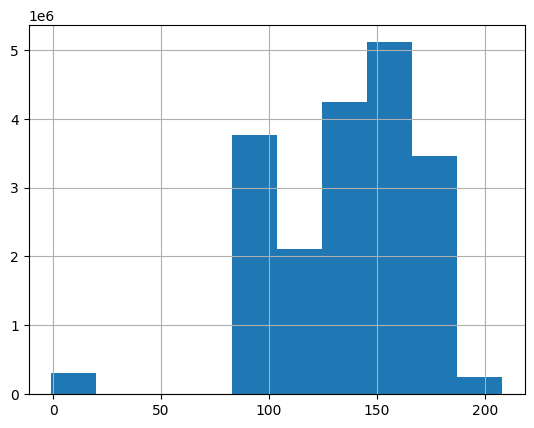

In [37]:
receipt_df['item_cat'].hist()

In [38]:
receipt_df['item_cat'].value_counts()

170    2930618
162    1887695
135    1862759
101    1341328
146     987452
        ...   
184          8
203          6
149          5
145          4
207          4
Name: item_cat, Length: 112, dtype: int64

In [39]:
cat_map_to_arti = {i[1]: i[0] for i in enumerate(receipt_df['item_cat'].unique())}
cat_map_to_real = {i[0]: i[1] for i in enumerate(receipt_df['item_cat'].unique())}

In [40]:
receipt_df['item_cat'] = [cat_map_to_arti[cat] for cat in receipt_df['item_cat']]

In [41]:
print(f"Уникальных значений в столбце 'item_cat':   {receipt_df['item_cat'].nunique()}")
print(f"Максимальное значение в столбце 'item_cat': {receipt_df['item_cat'].max()}")
print(f"Минимальное значение в столбце 'item_cat':  {receipt_df['item_cat'].min()}")

Уникальных значений в столбце 'item_cat':   112
Максимальное значение в столбце 'item_cat': 111
Минимальное значение в столбце 'item_cat':  0


In [42]:
receipt_df['item_cat'] = receipt_df['item_cat'].astype('int8')

### Анализ столбца 'item'

In [43]:
print(f"Уникальных значений в столбце 'item':   {receipt_df['item'].nunique()}")
print(f"Максимальное значение в столбце 'item': {receipt_df['item'].max()}")
print(f"Минимальное значение в столбце 'item':  {receipt_df['item'].min()}")

Уникальных значений в столбце 'item':   36036
Максимальное значение в столбце 'item': 363586
Минимальное значение в столбце 'item':  8086


In [44]:
# удаляем пакеты
receipt_df = receipt_df.query('item not in [168308]')
receipt_df.shape

(19106224, 9)

Проведем энкодинг значений столбца item, чтобы они начинались с нуля и по порядку. Это облегчит вычисления.

In [45]:
item_map_to_arti = {i[1]: i[0] for i in enumerate(receipt_df['item'].unique())}
item_map_to_real = {i[0]: i[1] for i in enumerate(receipt_df['item'].unique())}

In [46]:
receipt_df['item'] = [item_map_to_arti[item] for item in receipt_df['item']]

In [47]:
print(f"Уникальных значений в столбце 'item':   {receipt_df['item'].nunique()}")
print(f"Максимальное значение в столбце 'item': {receipt_df['item'].max()}")
print(f"Минимальное значение в столбце 'item':  {receipt_df['item'].min()}")

Уникальных значений в столбце 'item':   36035
Максимальное значение в столбце 'item': 36034
Минимальное значение в столбце 'item':  0


In [48]:
receipt_df['item'] = receipt_df['item'].astype('int32')

### Анализ столбца 'shop'

In [49]:
print(f"Уникальных значений в столбце 'shop':   {receipt_df['shop'].nunique()}")
print(f"Максимальное значение в столбце 'shop': {receipt_df['shop'].max()}")
print(f"Минимальное значение в столбце 'shop':  {receipt_df['shop'].min()}")

Уникальных значений в столбце 'shop':   849
Максимальное значение в столбце 'shop': 2168
Минимальное значение в столбце 'shop':  1


In [50]:
shop_map_to_arti = {i[1]: i[0] for i in enumerate(receipt_df['shop'].unique())}
shop_map_to_real = {i[0]: i[1] for i in enumerate(receipt_df['shop'].unique())}

In [51]:
receipt_df['shop'] = [shop_map_to_arti[shop] for shop in receipt_df['shop']]

In [52]:
print(f"Уникальных значений в столбце 'shop':   {receipt_df['shop'].nunique()}")
print(f"Максимальное значение в столбце 'shop': {receipt_df['shop'].max()}")
print(f"Минимальное значение в столбце 'shop':  {receipt_df['shop'].min()}")

Уникальных значений в столбце 'shop':   849
Максимальное значение в столбце 'shop': 848
Минимальное значение в столбце 'shop':  0


In [53]:
receipt_df['shop'] = receipt_df['shop'].astype('int16')

### Анализ столбца 'user'

In [54]:
print(f"Уникальных значений в столбце 'user':   {receipt_df['user'].nunique()}")
print(f"Максимальное значение в столбце 'user': {receipt_df['user'].max()}")
print(f"Минимальное значение в столбце 'user':  {receipt_df['user'].min()}")

Уникальных значений в столбце 'user':   1640397
Максимальное значение в столбце 'user': 2746262
Минимальное значение в столбце 'user':  373


In [55]:
user_map_to_arti = {i[1]: i[0] for i in enumerate(receipt_df['user'].unique())}
user_map_to_real = {i[0]: i[1] for i in enumerate(receipt_df['user'].unique())}

In [56]:
receipt_df['user'] = [user_map_to_arti[user] for user in receipt_df['user']]

In [57]:
print(f"Уникальных значений в столбце 'user':   {receipt_df['user'].nunique()}")
print(f"Максимальное значение в столбце 'user': {receipt_df['user'].max()}")
print(f"Минимальное значение в столбце 'user':  {receipt_df['user'].min()}")

Уникальных значений в столбце 'user':   1640397
Максимальное значение в столбце 'user': 1640396
Минимальное значение в столбце 'user':  0


In [58]:
receipt_df['user'] = receipt_df['user'].astype('int32')

### Анализ столбца 'sales_date'

In [59]:
print(f"Уникальных значений в столбце 'sale_date':   {receipt_df['sale_date'].nunique()}")
print(f"Максимальное значение в столбце 'sale_date': {receipt_df['sale_date'].max()}")
print(f"Минимальное значение в столбце 'sale_date':  {receipt_df['sale_date'].min()}")

Уникальных значений в столбце 'sale_date':   214
Максимальное значение в столбце 'sale_date': 2018-12-09 00:00:00
Минимальное значение в столбце 'sale_date':  2018-01-01 00:00:00


Для анализа по временным характеристикам разделим столбец 'sales_date' на составляющие:

In [60]:
receipt_df['year'] = receipt_df.sale_date.dt.year.astype('int16')
receipt_df['month'] = receipt_df.sale_date.dt.month.astype('int8')
receipt_df['day_of_year'] = receipt_df.sale_date.dt.day_of_year.astype('int16')
receipt_df['day_of_week'] = receipt_df.sale_date.dt.day_of_week.astype('int8')

In [61]:
receipt_df['day_of_month'] = receipt_df.sale_date.dt.day.astype('int8')
receipt_df.drop(columns=['sale_date'], inplace=True)

Посмотрим на распределение временных характеристик:

In [62]:
receipt_df['year'].value_counts()

2018    19106224
Name: year, dtype: int64

<Axes: >

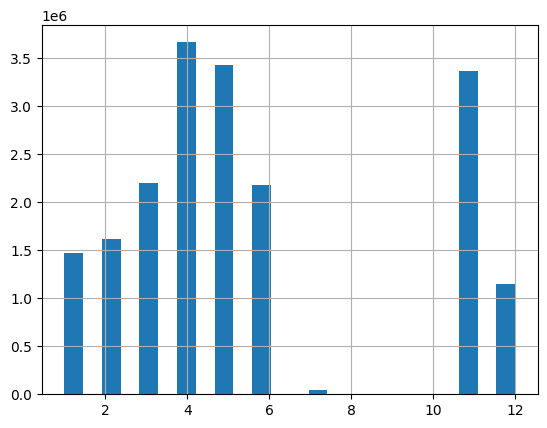

In [63]:
receipt_df['month'].hist(bins=24)

<Axes: >

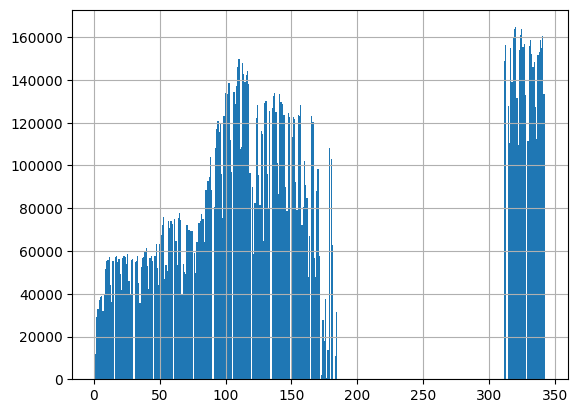

In [64]:
receipt_df['day_of_year'].hist(bins=365)

<Axes: >

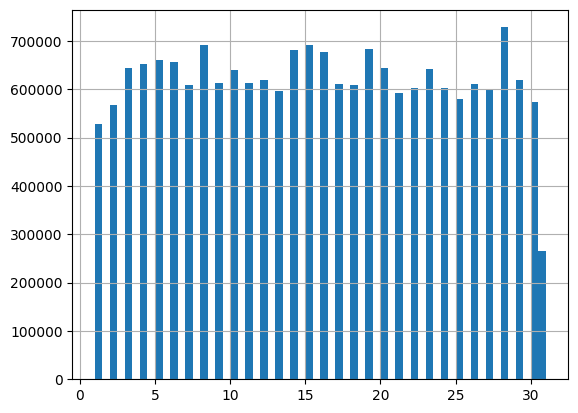

In [65]:
receipt_df['day_of_month'].hist(bins=60)

<Axes: >

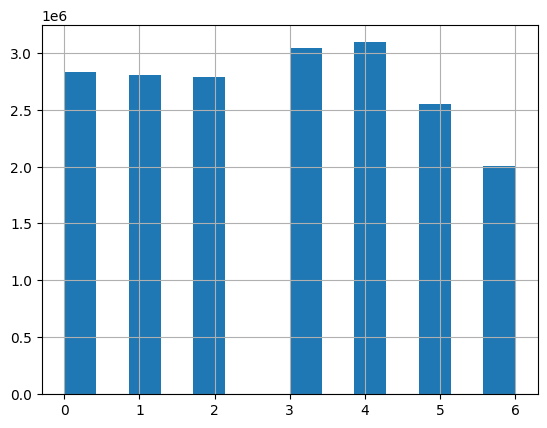

In [66]:
receipt_df['day_of_week'].hist(bins=14)

Можно сделать следующие выводы:
1. данные представлены только за 2018 год;
2. отсутствуют данные с июля по октябрь;
3. наблюдается положительный тренд роста числа продаж в течение года;
4. в течение месяца продажи распределены равномерно;
5. в течение недели продажи также распределены равномерно с небольшим спадом в воскресенье.

## Итоги EDA

In [67]:
receipt_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19106224 entries, 1 to 19999999
Data columns (total 13 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   user          int32 
 1   shop          int16 
 2   item          int32 
 3   name          object
 4   item_sub_cat  int16 
 5   item_cat      int8  
 6   brand         int64 
 7   quantity      int32 
 8   year          int16 
 9   month         int8  
 10  day_of_year   int16 
 11  day_of_week   int8  
 12  day_of_month  int8  
dtypes: int16(4), int32(3), int64(1), int8(4), object(1)
memory usage: 874.6+ MB


In [68]:
receipt_df.describe()

,user,shop,item,item_sub_cat,item_cat,brand,quantity,year,month,day_of_year,day_of_week,day_of_month
count,1.910622e+07,1.910622e+07,1.910622e+07,1.910622e+07,1.910622e+07,1.910622e+07,1.910622e+07,19106224.0,1.910622e+07,1.910622e+07,1.910622e+07,1.910622e+07
mean,6.343121e+05,2.090514e+02,3.578823e+03,5.319968e+01,1.590574e+01,4.156853e+02,1.301489e+00,2018.0,5.614627e+00,1.551911e+02,2.859853e+00,1.572141e+01
std,4.436883e+05,1.505922e+02,4.744117e+03,5.312149e+01,1.417480e+01,1.003859e+03,1.054556e+00,0.0,3.417428e+00,1.038032e+02,1.919760e+00,8.700816e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,1.000000e+00,2018.0,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00
25%,2.453370e+05,7.000000e+01,6.610000e+02,9.000000e+00,7.000000e+00,-1.000000e+00,1.000000e+00,2018.0,3.000000e+00,8.500000e+01,1.000000e+00,8.000000e+00
50%,5.628880e+05,2.180000e+02,1.908000e+03,3.400000e+01,1.200000e+01,-1.000000e+00,1.000000e+00,2018.0,5.000000e+00,1.270000e+02,3.000000e+00,1.600000e+01
75%,9.686660e+05,2.730000e+02,4.831000e+03,7.600000e+01,2.000000e+01,-1.000000e+00,1.000000e+00,2018.0,6.000000e+00,1.790000e+02,4.000000e+00,2.300000e+01
max,1.640396e+06,8.480000e+02,3.603400e+04,4.390000e+02,1.110000e+02,5.475000e+03,1.000000e+01,2018.0,1.200000e+01,3.430000e+02,6.000000e+00,3.100000e+01


In [69]:
receipt_df.head(3)

,user,shop,item,name,item_sub_cat,item_cat,brand,quantity,year,month,day_of_year,day_of_week,day_of_month
1,0,0,0,(62448) Перекись водорода р-р наружн. 3% фл.по...,1,1,-1,1,2018,12,341,4,7
2,1,1,1,(72183) Салициловая кислота р-р спирт 2% фл 40...,1,1,-1,1,2018,12,341,4,7
3,2,2,2,(197309) Пакет 28см х 50см,0,0,-1,1,2018,12,341,4,7


# Формирование тренировочной и тестовой выборок. Метрики качества

In [70]:
copy_receipt_df = receipt_df.copy()

In [71]:
# сортируем данные
receipt_df = receipt_df.sort_values(by=['day_of_year', 'user', 'shop']).reset_index(drop=True)
receipt_df

,user,shop,item,name,item_sub_cat,item_cat,brand,quantity,year,month,day_of_year,day_of_week,day_of_month
0,95,73,2395,(180814) Аквалор софт спрей наз. 150мл,167,12,2531,1,2018,1,1,0,1
1,95,73,564,"(24484) Тизин Классик/Ксило спрей наз. 0,05% ф...",23,12,-1,1,2018,1,1,0,1
2,95,73,2752,(42763) Солкосерил гель глазной 20% 5 гр.,7,6,-1,1,2018,1,1,0,1
3,95,73,24778,(44543) Витабакт капли глазн 0.05% фл 10мл N1,7,6,-1,1,2018,1,1,0,1
4,297,156,574,(65704) Эрмиталь капс.10000 ЕД №20,59,3,-1,1,2018,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19106219,77586,22,3788,(120922) Сульфасалазин табл. п.п.о. 500 мг. №50,112,3,-1,1,2018,12,343,6,9
19106220,77586,22,3788,(120922) Сульфасалазин табл. п.п.о. 500 мг. №50,112,3,-1,2,2018,12,343,6,9
19106221,77586,22,2686,(112839) Сульфасалазин-ЕН табл. п.о. раствор./...,3,3,-1,4,2018,12,343,6,9
19106222,77586,22,2686,(112839) Сульфасалазин-ЕН табл. п.о. раствор./...,3,3,-1,8,2018,12,343,6,9


In [72]:
# посмотрим на значение 70-го процентиля, по которому будем делить датасет на выборки
receipt_df['day_of_year'].quantile(0.7)

161.0

In [73]:
# разбиваем данные на train и test
df_train = receipt_df[receipt_df['day_of_year'] < receipt_df['day_of_year'].quantile(0.7)]
df_test  = receipt_df[receipt_df['day_of_year'] >= receipt_df['day_of_year'].quantile(0.7)]
print(f'Train: {df_train.shape}')
print(f'Test: {df_test.shape}')

Train: (13291207, 13)
Test: (5815017, 13)


In [74]:
# группируем товары из тестовой выборки по корзинам
s_ds = df_test.groupby(['day_of_year','user','shop'])['item'].agg([list])
s_ds.shape

(2001820, 1)

In [75]:
sale_idxs = pd.Series([i for i in range(s_ds.shape[0])])
s_ds = s_ds.set_index(sale_idxs)
s_ds

,list
0,"[647, 161, 8218, 1730, 0, 2169]"
1,"[29140, 14217, 14525, 14525]"
2,"[4345, 9247, 7671, 14525, 6254, 5546, 1249, 1942]"
3,"[2317, 19358]"
4,[35270]
...,...
2001815,[2111]
2001816,[1142]
2001817,"[497, 7682]"
2001818,"[3870, 1070, 2745, 9337]"


In [76]:
# метрики качества, которые будем использовать далее

def precision_at_k(y_true, y_pred, k):
    result = 0.0
    if k < 1 or k > len(y_pred):
        return result
    else:
        y_pred = y_pred[:k]
    correct_indeces = np.where(np.in1d(y_pred, y_true))[0]
    result = len(correct_indeces) / k
    return result

def average_precision(y_true, y_pred):
    result = 0.0
    correct_indeces = np.where(np.in1d(y_pred, y_true))[0]
    size = len(correct_indeces)
    if size == 0:
        return result
    p_at_k = np.array([precision_at_k(y_true, y_pred, k) for k in np.arange(1, size + 1)])
    result = np.sum(p_at_k) / size
    return result

def mean_average_precision(y_true_list, y_pred_list):
    result = 0
    assert len(y_true_list) == len(y_pred_list)

    for pair in zip(y_true_list, y_pred_list):
        result += average_precision(pair[0], pair[1])
    return result / len(y_true_list)


def compute_metric(test_data, y_pred, metric='MAP'):
    
    cum_sum = 0
    
    for i in range(test_data.shape[0]):
        y_true = test_data['shop_list'].iloc[i]
        AP = average_precision(y_true, y_pred)
        cum_sum += AP
        
    if metric=='MAP':
        MAP = cum_sum / test_data.shape[0]
    
    return MAP

# Popularity-based подход

In [78]:
items = set(df_train['item'])
top_sales = {item: 0 for item in items}

for item in df_train['item']:
    top_sales[item] += 1

top_sales = {k: v for k, v in sorted(top_sales.items(), key=lambda item: -item[1])}

In [79]:
def popularity_based(top_sales=top_sales, n=5, return_real=False):
    
    # если нужны текстовые наименования рекомендованных товаров
    if return_real:
        return [product_dict[str(item_map_to_real[item])] for item in list(top_sales.keys())[:n]]
    # если нужны индексы (для расчета метрик нужны именно они)
    return list(top_sales.keys())[:n]

In [80]:
popularity_based(n=5)

[12, 321, 702, 67, 350]

In [81]:
popularity_preds = popularity_based(n=5)

In [82]:
s_ds.columns = ['shop_list']
compute_metric(s_ds, popularity_preds, metric='MAP')

0.014851637787391294

**Popularity-based подход MAP = 0.01485**

# Случайные рекомендации

## Рекомендация 5 случайных позиций

In [83]:
def random_rec(n=5):
    return np.random.choice(list(set(df_train['item'])), 5)

In [84]:
np.random.seed(50)
random_preds = random_rec(n=5)
random_preds

array([16666,  5958, 11040, 29368, 19411])

In [85]:
print(compute_metric(s_ds, random_preds, metric='MAP'))

2.9972724820413424e-06


При случайной генерации рекомендаций получаем значение метрики MAP близкое к нулю.

## Случайная рекомендация 5 позиций из top-100 по популярности товаров

In [86]:
items = set(df_train['item'])
top_sales = {item: 0 for item in items}

for item in df_train['item']:
    top_sales[item] += 1
    
top_sales = {k: v for k, v in sorted(top_sales.items(), key=lambda item: -item[1])}

In [87]:
def random_rec_tresh(top_sales=top_sales, tresh=100, n=5):
    list(top_sales.keys())[:tresh]
    return np.random.choice(list(top_sales.keys())[:tresh], 5)

In [88]:
np.random.seed(50)
random_preds_tresh = random_rec_tresh(tresh=100, n=5)
random_preds_tresh

array([ 240, 1314,  519,  263, 1623])

In [89]:
print(compute_metric(s_ds, random_preds_tresh, metric='MAP'))

0.004768577261358831


Рандомная генерация рекомендаций из топ-100 item по продажам ожидаемо показывает результат получше, однако наивная реализация топ-5 рекомендаций значительно обходит и эту версию.

# Content-based подход

Для начала сгруппируем товары по корзинам, для этого группируем те товары, у которых совпадают одновременно 3 столбца:

In [90]:
shop_list_train = df_train.groupby(['day_of_year','user','shop'])['item'].agg([list])
shop_list_train.shape

(4110995, 1)

In [91]:
sale_idxs_train = pd.Series([i for i in range(shop_list_train.shape[0])])
shop_list_train = shop_list_train.set_index(sale_idxs_train)
shop_list_train.columns = ['shop_list']
shop_list_train

,shop_list
0,"[2395, 564, 2752, 24778]"
1,[574]
2,[2243]
3,[1655]
4,"[12, 4367, 2137]"
...,...
4110990,[7490]
4110991,[9469]
4110992,[8201]
4110993,[11304]


In [93]:
# среднее количество позиций в корзине
np.mean([len(i) for i in shop_list_train['shop_list']])

3.2330876101770984

In [102]:
max_item_id = max(shop_list_train['shop_list'])[0]
max_item_id

35959

In [103]:
# создадим матрицу item-item
item_item_matrix = np.zeros((max_item_id, max_item_id))
item_item_matrix.shape

(35959, 35959)

In [104]:
for shop_list in tqdm(shop_list_train['shop_list']):
    length = len(shop_list)
    if length > 1:
        for i in range(length):
            item1 = shop_list[i]
            try:
                for j in range(i+1, length):
                    item2 = shop_list[j]
                    item_item_matrix[item1][item2] += 1
                    
            # на всякий случай обработаем ошибку, если попадет не тот индекс
            except IndexError:
                pass

  0%|          | 0/4110995 [00:00<?, ?it/s]

In [105]:
def top_k_items(item_id, top_k, corr_mat, return_real=False):
    top_items = corr_mat[item_id, :].argsort()[-top_k:][::-1] 
    if return_real:
        top_items = [product_dict[str(item_map_to_real[e])] for e in top_items]
    return top_items

In [106]:
top_k_items(350, 5, item_item_matrix, return_real=True)

['(57733) Корвалол капли д/приема внутрь 25мл 738',
 '(20116) Тауфон капли глазн 4% фл 10 мл. пласт. флак.-кап. 575',
 '(117825) Панангин таб.п.п.о.№50 738',
 '(118125) Кардиомагнил таб.п.п.о.75мг №100 738',
 '(42996) Найз таб.100мг №20 647']

In [107]:
top_k_items(350, 5, item_item_matrix, return_real=False)

array([ 12,  67, 321, 702, 661], dtype=int64)

In [108]:
# функция для генераций рекомендаций на всю тестовую выборку
# функция нужна для дальнейшего расчета MAP на тестовой выборке

def content_based(item_list, corr_mat, n=5, return_real=False):
    
    length = len(item_list)
    if length >= n:
        top_k = (length // n) + 1
    else:
        top_k = 1

    candidates = []
    try:
        if return_real:
            for item in item_list:
                candidates.append(top_k_items(item, top_k, corr_mat, return_real=True))
        else:
            for item in item_list:
                candidates.append(top_k_items(item, top_k, corr_mat, return_real=False))
    except IndexError:
        pass
            
    candidates = [item for sublist in candidates for item in sublist]
    
    try:
        rec_list = np.random.choice(candidates, n)
    # обработаем ошибку на случай пустого списка candidates
    except ValueError:
        rec_list = []
        
    return rec_list

In [110]:
# функция подсчета MAP
def compute_map_content_based(test_data):
    cum_sum = 0
    for  i in tqdm(range(test_data.shape[0])):
        y_true = test_data['shop_list'].iloc[i]
        y_pred = content_based([y_true[0]], item_item_matrix)
        AP = average_precision(y_true, y_pred)
        cum_sum += AP
    MAP = cum_sum / test_data.shape[0]
    return MAP

In [111]:
compute_map_content_based(s_ds)

  0%|          | 0/2001820 [00:00<?, ?it/s]

0.054369523733402605

**Content-based подход MAP = 0.054**

Результат в 5 раз лучше по метрике MAP, чем при использовании подхода к предсказанию топ-n самых популярных item.

# Модель с использованием эмбеддингов

In [112]:
# для фильтрации пунктуации
exclude = set(string.punctuation)
# для приведения слов к начальной форме
morpher = MorphAnalyzer()
# для фильтрации стоп-слов
sw = get_stop_words("ru")

def preprocess_text(line):
    spls = "".join(i for i in str(line).strip() if i not in exclude).split()
    spls = [morpher.parse(i.lower())[0].normal_form for i in spls]
    spls = [i for i in spls if i not in sw and i != ""]
    # также удалим отдельностоящие числа
    spls = [i for i in spls if not i.isdigit()]
    # и некоторые знаки пунктуации
    spls = [re.sub(r'[]!"$%&\'()*+,/:;=#@?[\\^_`{|}~-]+', "", i) for i in spls]
    return spls

sentences = [preprocess_text(k) for k in product_dict.values()]

In [113]:
products_df

,product_id,product
0,168308,(197312) Пакет-майка 25см х 45см 906
1,134832,(62448) Перекись водорода р-р наружн. 3% фл.по...
2,101384,(72183) Салициловая кислота р-р спирт 2% фл 40...
3,168570,(197309) Пакет 28см х 50см 906
4,146960,"(111023) Пакет ""Аптека Озерки"" 28 х 35см 906"
...,...,...
30413,193603,(110044169) название -1
30414,193484,(110050486) название -1
30415,192459,(110020427) название -1
30416,193510,(110047818) название -1


In [114]:
products_df['sentences'] = sentences
products_df.head()

,product_id,product,sentences
0,168308,(197312) Пакет-майка 25см х 45см 906,"[пакетмайк, 25см, х, 45см]"
1,134832,(62448) Перекись водорода р-р наружн. 3% фл.по...,"[перекись, водород, рр, наружн, флполимерна, 1..."
2,101384,(72183) Салициловая кислота р-р спирт 2% фл 40...,"[салициловый, кислота, рр, спирт, фл, 40мл, n1]"
3,168570,(197309) Пакет 28см х 50см 906,"[пакет, 28см, х, 50см]"
4,146960,"(111023) Пакет ""Аптека Озерки"" 28 х 35см 906","[пакет, аптека, озерко, х, 35см]"


In [115]:
# для построения эмбеддингов будем использовать FastText
modelFT = FastText(sentences=sentences, vector_size=20, min_count=1, window=5)
modelFT.build_vocab(sentences, update=True)
modelFT.train(sentences, total_examples=len(sentences), epochs=5)

(787320, 845705)

In [117]:
# в данных есть одна строка с item=-1, исключаем ее
products_df = products_df[products_df['product_id'] >= 0]

In [118]:
# для нахождения k-ближайших соседей будем использовать библиотеку Annoy (Approximate Nearest Neighbors)
# из-за ее быстроты в сравнении с реализацией knn из scikit-learn
ft_index_names = annoy.AnnoyIndex(20 ,'angular')

for i in tqdm(range(products_df.shape[0])):
    # слова склеиваем в единое предложение для последуещей генерации вектора эмбеддинга для целого предложения
    sentence = [' '.join(products_df['sentences'].iloc[i])]
    # добавляем индекс item и значение вектора эмбеддинга для item
    ft_index_names.add_item(products_df['product_id'].iloc[i], modelFT.wv[sentence][0])
    
ft_index_names.build(10)

  0%|          | 0/30417 [00:00<?, ?it/s]

True

In [119]:
# проверяем
ft_index_names.get_nns_by_item(192141, 5)

[25910, 27054, 57786, 58831, 59600]

In [122]:
# функция подсчета MAP
def compute_map_fasttext(test_data, n=5):
    cum_sum = 0
    for  i in tqdm(range(test_data.shape[0])):
        y_true = test_data['shop_list'].iloc[i]
        y_pred = ft_index_names.get_nns_by_item(y_true[0], n=5)
        AP = average_precision(y_true, y_pred)
        cum_sum += AP
    MAP = cum_sum / test_data.shape[0]
    return MAP

In [123]:
compute_map_fasttext(s_ds)

  0%|          | 0/2001820 [00:00<?, ?it/s]

0.0008517249303134148

Результаты оказались значительно хуже других подходов, что вполне объяснимо: выдавать рекомендации на основе близости лекарств по названиям довольно странная затея.